In [1]:
# Download dataset. This is not needed if you have the dataset already

# import kagglehub

# path = kagglehub.dataset_download("uwrfkaggler/ravdess-emotional-speech-audio")

# print("Path to dataset files:", path)

# Data Cleaning and Reformatting

In [2]:
# Function to check the sampling rate of a wav file and valid file path

import wave
import contextlib

def check_sampling_rate(file_path):
    try:
        with contextlib.closing(wave.open(file_path, 'r')) as wav_file:
            sample_rate = wav_file.getframerate()
            print(f"Sampling rate: {sample_rate} Hz")
    except Exception as e:
        print(f"Error: {e}")

file_path = 'data/ravdess-emotional-speech-audio/versions/1/Actor_01/03-01-01-01-01-01-01.wav'
check_sampling_rate(file_path)

Sampling rate: 48000 Hz


In [3]:
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T

import librosa as librosa
import matplotlib.pyplot as plt

import numpy as  np

In [4]:
"""
File naming convention

Each of the 1440 files has a unique filename. The filename consists of a 7-part numerical identifier (e.g., 03-01-06-01-02-01-12.wav). These identifiers define the stimulus characteristics:

Filename identifiers

Modality (01 = full-AV, 02 = video-only, 03 = audio-only).

Vocal channel (01 = speech, 02 = song).

Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).

Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.

Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").

Repetition (01 = 1st repetition, 02 = 2nd repetition).
"""


import os
import pandas as pd

emotion_mapping = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}

file_dir = "data/ravdess-emotional-speech-audio/versions/1/"

data = []

for actor in os.listdir(file_dir):
    actor_path = os.path.join(file_dir, actor)
    
    if os.path.isdir(actor_path) and actor.startswith("Actor_"):
        actor_number = actor.split("_")[-1]

        for file in os.listdir(actor_path):
            if file.endswith(".wav"):
                emotion_code = file[6:8]
                emotion = emotion_mapping.get(emotion_code, "unknown")
                #formatted_filename = f"Actor_{actor_number}_{file}"
                data.append({"emotion": emotion, "file_path": file, "Actor": actor})

df = pd.DataFrame(data)

print(df)

        emotion                 file_path     Actor
0       disgust  03-01-07-01-02-01-24.wav  Actor_24
1     surprised  03-01-08-02-01-01-24.wav  Actor_24
2           sad  03-01-04-01-02-01-24.wav  Actor_24
3         angry  03-01-05-01-01-01-24.wav  Actor_24
4           sad  03-01-04-02-01-01-24.wav  Actor_24
...         ...                       ...       ...
1435    neutral  03-01-01-01-01-01-07.wav  Actor_07
1436      happy  03-01-03-02-01-02-07.wav  Actor_07
1437    neutral  03-01-01-01-01-02-07.wav  Actor_07
1438    disgust  03-01-07-02-01-02-07.wav  Actor_07
1439       calm  03-01-02-02-01-01-07.wav  Actor_07

[1440 rows x 3 columns]


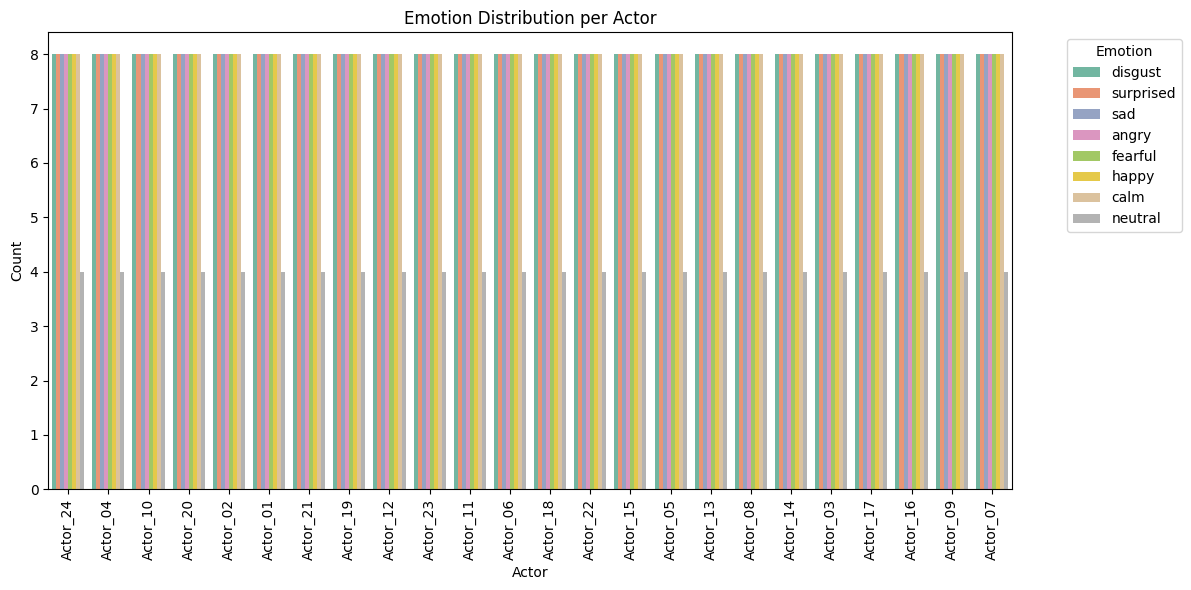

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='Actor', hue='emotion', palette='Set2')
plt.title('Emotion Distribution per Actor')
plt.xlabel('Actor')
plt.ylabel('Count')
plt.legend(title='Emotion', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [6]:
#remove calm emotion
df = df[df.emotion != 'calm']

# Extracting waveforms and spectograms

In [7]:
import random 

def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=random.uniform(-2, 2))

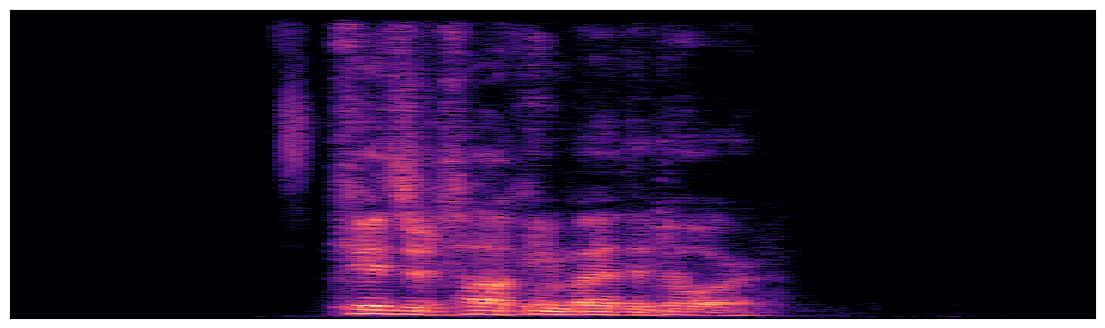

In [8]:
data, sample_rate = librosa.load(file_path)



x2 = stretch(data)
X = librosa.stft(x2)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14,4))
#librosa.display.waveshow(y=x2, sr=sample_rate)
librosa.display.specshow(data=Xdb)

In [13]:
from sklearn.preprocessing import StandardScaler

def extract_features(data, sample_rate):
    result = np.array([])

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft))

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=13).T, axis=0)
    result = np.hstack((result, mfcc))

    # RMS
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms))

    # Mel Spectrogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel))

    # Spectral Centroid
    centroid = np.mean(librosa.feature.spectral_centroid(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, centroid))

    # Spectral Rolloff
    rolloff = np.mean(librosa.feature.spectral_rolloff(y=data, sr=sample_rate, roll_percent=0.9).T, axis=0)
    result = np.hstack((result, rolloff))

    # Spectral Flux
    spectral_flux = np.sqrt(np.sum(np.diff(stft, axis=1)**2, axis=0))
    spectral_flux_mean = np.mean(spectral_flux)
    result = np.hstack((result, spectral_flux_mean))

    return result

scaler = StandardScaler()

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data, sample_rate)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data, sample_rate)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data, sample_rate)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch, sample_rate)
    result = np.vstack((result, res3)) # stacking vertically

    result = scaler.fit_transform(result)
    
    return result

In [14]:
#create train and test set 
from sklearn.model_selection import train_test_split

emotion_to_num = {
    "neutral": 0,
    "happy": 1,
    "sad": 2,
    "angry": 3,
    "fearful": 4,
    "disgust": 5,
    "surprised": 6
}

train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['Actor'], random_state=42)

train_set, test_set = [], []
#loop through df and generate tuple objects for tensors and labels 
for i in range(len(train_df)):
  input_features = torch.from_numpy(get_features(os.path.join(file_dir, train_df.iloc[i]['Actor'], train_df.iloc[i]['file_path'])))
  label = torch.tensor(emotion_to_num[train_df.iloc[i]['emotion']], dtype=torch.long)
  train_set.append((input_features, label))

for i in range(len(test_df)):
  input_features = torch.from_numpy(get_features(os.path.join(file_dir, test_df.iloc[i]['Actor'], test_df.iloc[i]['file_path'])) )
  label = torch.tensor(emotion_to_num[test_df.iloc[i]['emotion']], dtype=torch.long)
  test_set.append((input_features, label))

/home/ubuntu/.local/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=2
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/home/ubuntu/.local/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/.local/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/.local/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=2
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/home/ubunt

KeyboardInterrupt: 

In [ ]:
BATCH_SIZE = 8  # <-- Please change this as necessary
NUM_WORKERS = 4  # <-- Use more workers for more CPU threads

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS)

test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS)

# Creating the model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


In [ ]:
df['emotion'].value_counts()